# StackOverflow Problems

### Real-world problems to test your skills on!

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import (filters, io, color, exposure, feature,
                     segmentation, morphology, img_as_float)

# Parameters of a pill

(Based on StackOverflow http://stackoverflow.com/questions/28281742/fitting-a-circle-to-a-binary-image)

<img src="../images/round_pill.jpg" width="200px" style="float: left; padding-right: 1em;"/>
Consider a pill from the [NLM Pill Image Recognition Pilot](http://pir.nlm.nih.gov/pilot/instructions.html) (``../images/round_pill.jpg``).  Fit a circle to the pill outline and compute its area.

<div style="clear: both;"></div>

*Hints:*

1. Equalize (``exposure.equalize_*``)
2. Detect edges (``filter.canny`` or ``feature.canny``--depending on your version)
3. Fit the ``CircleModel`` using ``measure.ransac``.

### Alternative: morphological snakes

**NOTE**: this is expensive to compute, so may take a while to execute

In [ ]:
# Initial level set
pill = color.rgb2gray(image)
pill = restoration.denoise_nl_means(pill, multichannel=False)

level_set = segmentation.circle_level_set(pill.shape, radius=200)
ls = segmentation.morphological_chan_vese(pill, 80, init_level_set=level_set, smoothing=3)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(pill, cmap="gray")
ax.set_axis_off()
ax.contour(ls, [0.5], colors='r');

# Counting coins

Based on StackOverflow http://stackoverflow.com/questions/28242274/count-number-of-objects-using-watershed-algorithm-scikit-image

Consider the coins image from the scikit-image example dataset, shown below.
Write a function to count the number of coins.

The procedure outlined here is a bit simpler than in the notebook lecture (and works just fine!)

<div style="clear: both;"></div>

*Hint:*

1. Equalize
2. Threshold (``filters.threshold_otsu``)
3. Remove objects touching boundary (``segmentation.clear_border``)
4. Apply morphological closing (``morphology.closing``)
5. Remove small objects (``measure.regionprops``)
6. Visualize (potentially using ``color.label2rgb``)

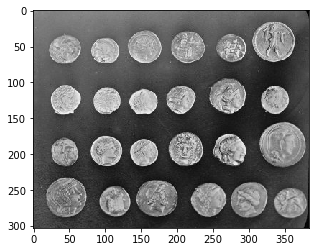

In [3]:
from skimage import data
fig, ax = plt.subplots()
ax.imshow(data.coins(), cmap='gray');

# Snakes

Based on https://stackoverflow.com/q/8686926/214686

<img src="../images/snakes.png" width="200px" style="float: left; padding-right: 1em;"/>

Consider the zig-zaggy snakes on the left (``../images/snakes.png``).<br/>Write some code to find the begin- and end-points of each.

<div style="clear: both;"></div>

*Hints:*

1. Threshold the image to turn it into "black and white"
2. Not all lines are a single pixel thick.  Use skeletonization to thin them out (``morphology.skeletonize``)
3. Locate all snake endpoints (I used a combination of ``scipy.signal.convolve2d`` [find all points with only one neighbor], and ``np.logical_and`` [which of those points lie on the snake?] to do that, but there are many other ways).

# M&Ms

How many blue M&Ms are there in this image (`../images/mm.jpg`)?

<img src="../images/mm.jpg" width="400px"/>

Steps:

1. Denoise the image (using, e.g., `restoration.denoise_nl_means`)
2. Calculate how far each pixel is away from pure blue
3. Segment this distance map to give a "pill mask"
4. Fill in any holes in that mask, using `scipy.ndimage.binary_fill_holes`
5. Use watershed segmentation to split apart any M&Ms that were joined, as described in http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html

*Alternative approach:*

- http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

# Viscous fingers

Based on StackOverflow: http://stackoverflow.com/questions/23121416/long-boundary-detection-in-a-noisy-image

<img src="../images/fingers.png" width="200px" style="float: left; padding-right: 1em;"/>

Consider the fluid experiment on the right (`../images/fingers.png`).  Determine any kind of meaningful boundary in this noisy image.

<div style="clear: both;"></div>

*Hints:*

1. Convert to grayscale
2. Try edge detection (``feature.canny``)
3. If edge detection fails, denoising is needed (try ``restoration.denoise_tv_bregman``)
4. Try edge detection (``feature.canny``)